https://assets.press.princeton.edu/chapters/s2_10291.pdf

(This is the One-Compartment Model of Repeated Doses, question 3 near end of above pdf)

In [1]:
import reno as r

In [2]:
t = r.TimeRef()
compartment = r.Model("one_compartment_model", steps=168)
with compartment:
    drug_in_system = r.Stock(doc="mass of medication in the (\"person's blood serum\"?)")
    ingested = r.Flow(doc="Pulsed inflow of medication when dosage is taken.")
    eliminated = r.Flow(doc="Rate of change of drug leaving the system.")
    
    absorption_fraction = r.Variable(.12)
    dosage = r.Variable(100 * 1000, doc="Dosage is 100 * 1000 micrograms")
    start = r.Variable(0, doc="Timestep of first dosage. (in hours)")
    interval = r.Variable(8, doc="Timesteps between each dosage. (in hours)")
    
    volume = r.Variable(3000, doc="Volume of blood serum, 3000 mL") 
    concentration = r.Variable(drug_in_system / volume)
    half_life = r.Variable(22, doc="Half-life of medication. (in hours)")
    elimination_constant = r.Variable(-r.log(0.5) / half_life)
    
    eliminated.eq = elimination_constant * drug_in_system
    ingested.eq = absorption_fraction * dosage * r.repeated_pulse(start, interval)

    ingested >> drug_in_system >> eliminated

In [3]:
compartment.latex()

InteractiveLatex(events=['fire_on_row_clicked'], latex_output=Output(), template=Template(template='<template>…

In [4]:
ds = compartment()

one_compartment_model:   0%|          | 0/167 [00:00<?, ?it/s]

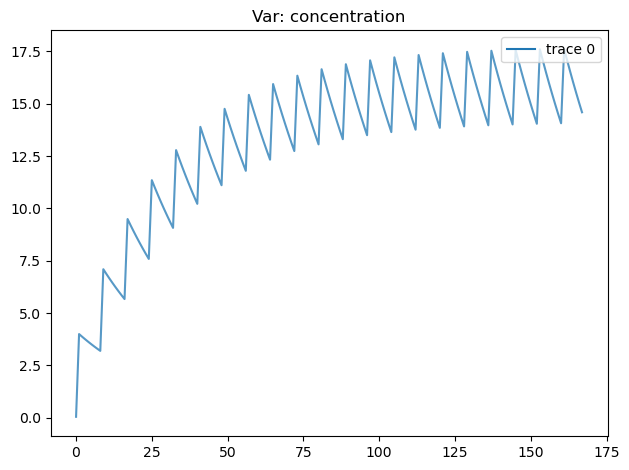

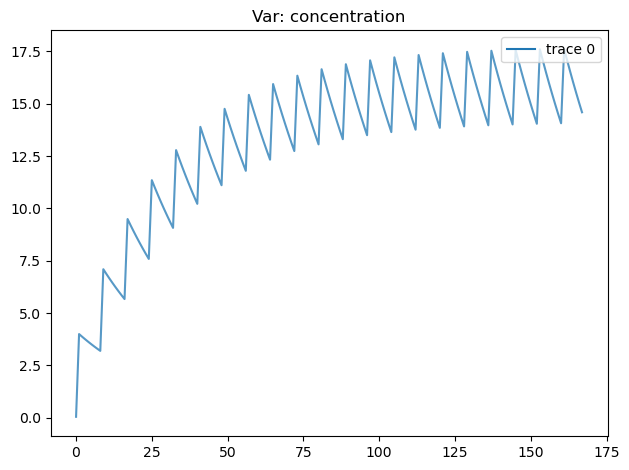

In [5]:
r.plot_trace_refs(compartment, [ds], [compartment.concentration])

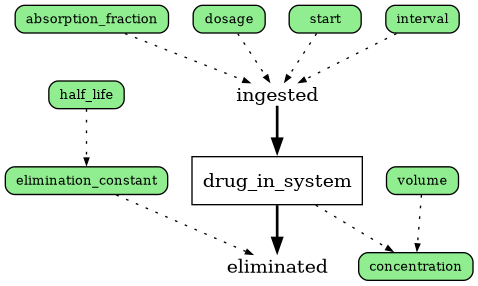

In [6]:
compartment.graph()

In [ ]:
compartment.graph(sparklines=True, sparkall=True)

Showing variance when run with probability distributions (varying dosage and absorption_fraction)

In [7]:
ds2 = compartment(steps=168, n=1000, dosage=r.Uniform(90*1000, 110*1000), absorption_fraction=r.Normal(.11, .025))
ds2

one_compartment_model:   0%|          | 0/167 [00:00<?, ?it/s]

<xarray.Dataset> Size: 5MB
Dimensions:               (sample: 1000, step: 168)
Coordinates:
  * sample                (sample) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * step                  (step) int64 1kB 0 1 2 3 4 5 ... 163 164 165 166 167
Data variables:
    drug_in_system        (sample, step) float64 1MB 0.0 1.429e+04 ... 3.9e+04
    ingested              (sample, step) float64 1MB 1.429e+04 0.0 ... 0.0 0.0
    eliminated            (sample, step) float64 1MB 0.0 450.2 ... 1.229e+03
    concentration         (sample, step) float64 1MB 0.0 4.763 ... 13.42 13.0
    absorption_fraction   (sample) float64 8kB 0.1315 0.1044 ... 0.1175 0.1015
    dosage                (sample) float64 8kB 1.087e+05 1.026e+05 ... 1.057e+05
    start                 (sample) int64 8kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    interval              (sample) int64 8kB 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8
    volume                (sample) int64 8kB 3000 3000 3000 ... 3000 3000 3000
    half_life             (sample) int64 8kB 22 22 22 22 22 ... 22 22 22 22 22
    elimination_constant  (sample) float64 8kB 0.03151 0.03151 ... 0.03151
Attributes:
    absorption_fraction:  Normal(0.11, 0.025)
    dosage:               Uniform(90000, 110000)
    start:                Scalar(0)
    interval:             Scalar(8)
    volume:               Scalar(3000)
    half_life:            Scalar(22)
    drug_in_system_0:     0

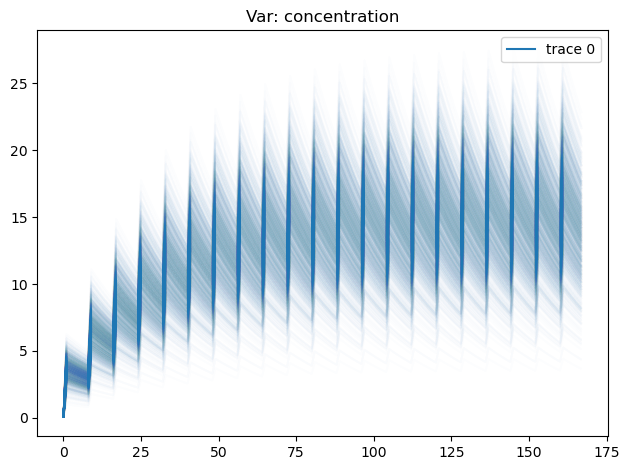

In [8]:
r.plot_trace_refs(compartment, [ds2], [compartment.concentration])

In [ ]:
# compartment.conc_100 = reno.Metric(compartment.concentration.timeseries[100])

Can we determine what dosage and absorption fraction would lead to a high concentration at a particular step?

In [9]:
trace0 = compartment.pymc(
    n=4000, 
    dosage=r.Uniform(90*1000, 110*1000), 
    absorption_fraction=r.Normal(.11, .1),
    observations=[
        r.Observation(compartment.concentration.timeseries[100], 2, [40])
    ],
)

Sampling: [absorption_fraction, dosage, observation_0_likelihood]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

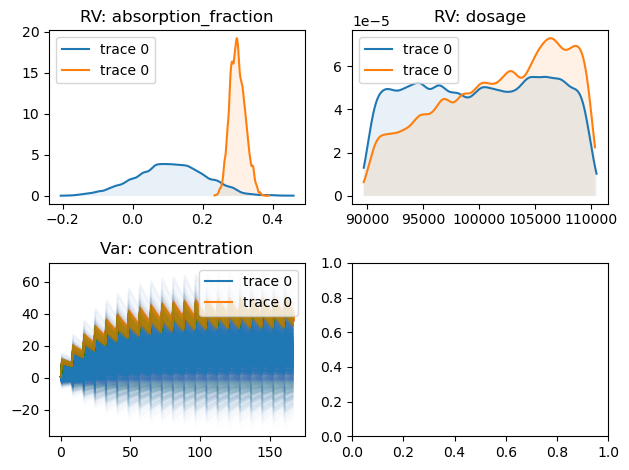

In [10]:
r.plot_trace_refs(compartment, [trace0.prior, trace0.posterior], [compartment.dosage, compartment.absorption_fraction, compartment.concentration])

Example problem: we want to determine the absorption fraction for a particular drug, where dosage is controlled but possible variance in start/interval times
Below are values for some observations we can make, with the goal to highlight how more observations improves posterior distributions

In [11]:
ds.concentration.values[0][100], ds.concentration.values[0][150], ds.concentration.values[0][30]

(np.float64(15.506441281203491),
 np.float64(14.968762367809141),
 np.float64(9.66949571014747))

In [12]:
# single observation case
trace1 = compartment.pymc(
    n=4000, 
    dosage=100*1000,
    start=r.DiscreteUniform(0, 1),
    interval=r.DiscreteUniform(7, 9),
    absorption_fraction=r.Normal(.15, .025),
    observations=[
        r.Observation(compartment.concentration.timeseries[100], 1, [15.5])
    ],
)


Sampling: [absorption_fraction, interval, observation_0_likelihood, start]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/81n/micromamba/envs/reno/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


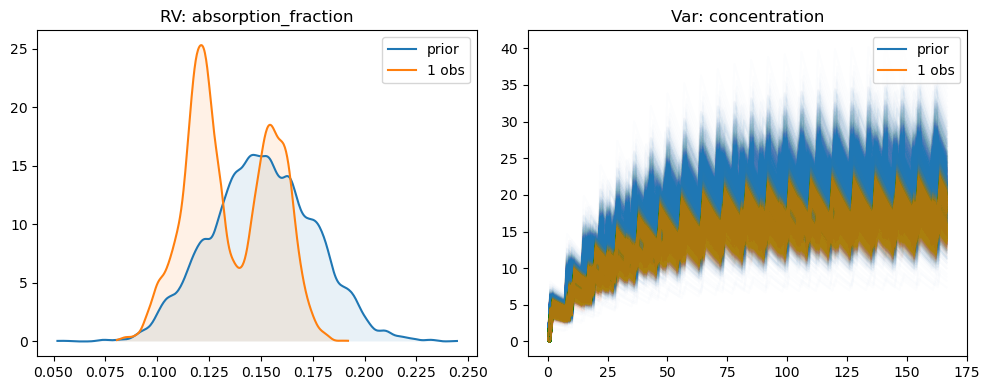

In [13]:
r.plot_trace_refs(
    compartment, 
    {"prior": trace1.prior, "1 obs": trace1.posterior}, 
    [compartment.absorption_fraction, compartment.concentration],
    figsize=(10, 4)
)

In [14]:
# two observed concentrations
trace2 = compartment.pymc(
    n=4000, 
    dosage=100*1000,
    start=r.DiscreteUniform(0, 1),
    interval=r.DiscreteUniform(7, 9),
    absorption_fraction=r.Normal(.15, .025),
    observations=[
        r.Observation(compartment.concentration.timeseries[100], 1, [15.5]),
        r.Observation(compartment.concentration.timeseries[150], 1, [15.0])
    ],
)

Sampling: [absorption_fraction, interval, observation_0_likelihood, observation_1_likelihood, start]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/81n/micromamba/envs/reno/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


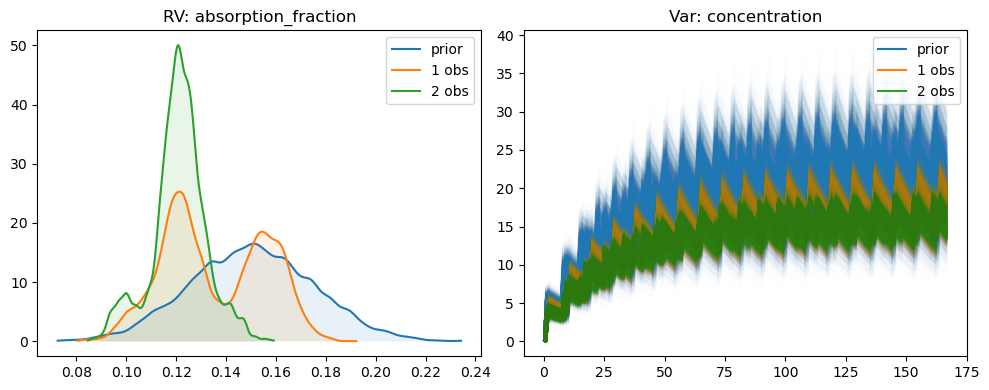

In [15]:
r.plot_trace_refs(
    compartment, 
    {"prior": trace2.prior, "1 obs": trace1.posterior, "2 obs": trace2.posterior}, 
    [compartment.absorption_fraction, compartment.concentration],
    figsize=(10, 4)
)


In [16]:
# three observations
trace3 = compartment.pymc(
    n=4000, 
    dosage=100*1000,
    start=r.DiscreteUniform(0, 1),
    interval=r.DiscreteUniform(7, 9),
    absorption_fraction=r.Normal(.15, .025),
    observations=[
        r.Observation(compartment.concentration.timeseries[100], 1, [15.5]),
        r.Observation(compartment.concentration.timeseries[150], 1, [15.0]),
        r.Observation(compartment.concentration.timeseries[30], 1, [9.5]),
    ],
)


Sampling: [absorption_fraction, interval, observation_0_likelihood, observation_1_likelihood, observation_2_likelihood, start]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/81n/micromamba/envs/reno/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


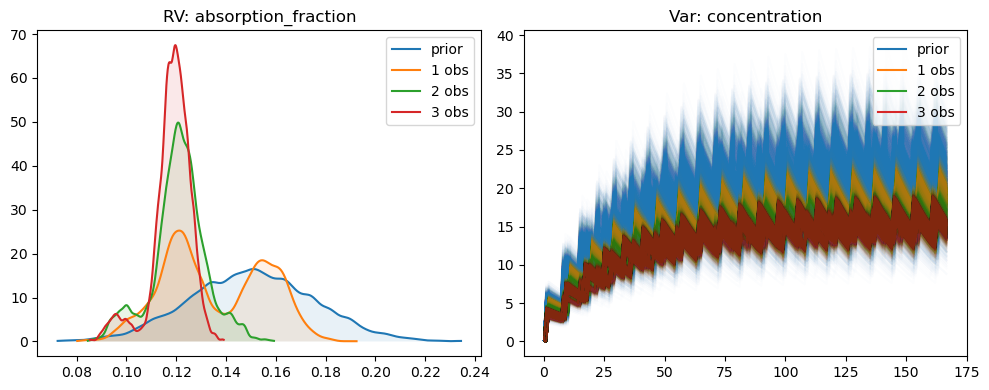

In [17]:
r.plot_trace_refs(
    compartment, 
    {"prior": trace2.prior, "1 obs": trace1.posterior, "2 obs": trace2.posterior, "3 obs": trace3.posterior},
    [compartment.absorption_fraction, compartment.concentration],
    figsize=(10, 4)
)

In [18]:
print("Predicted mean:".rjust(15), trace3.posterior.absorption_fraction.values.mean())
print("Actual value:".rjust(15), compartment.absorption_fraction.eq.value)

Predicted mean: 0.11827742333483988
  Actual value: 0.12


In [ ]:
compartment.graph(
    sparklines=True,
    sparkall=True,
    sparkdensities=True,
    traces=[trace3.prior, trace3.posterior],
    exclude_vars=["half_life", "dosage", "elimination_constant", "volume", "concentration"]
)